Алексеев Д.П. (DSU-4, NLP-4)_HW(3)_Thematic_modeling

Обработка естественного языка, ДЗ к лекции №3 "Тематическое моделирование".

Задание:
Классификация по тональности.

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.

Часть 1. Анализ текстов.

а) Посчитайте количество отзывов в разных городах и на разные банки.

б) Постройте гистограммы длин слов в символах и в словах.

в) Найдите 10 самых частых:
- слов.
- слов без стоп-слов.
- лемм.
- существительных.

г) Постройте кривые Ципфа и Хипса.

д) Ответьте на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

е) В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру tf-idf для того, чтобы найти ключевые слова и биграммы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1).

Часть 2. Тематическое моделирование.

а) Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

б) Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить? 

Эта часть задания может быть сделана с использованием gensim.

Часть 3. Классификация текстов.

а) Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

б) Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных n-грам.

в) Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант:  tf-idf преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.
В ноутбуке, размещенном в папке репозитория, написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

In [ ]:
# Скачаем json-файл с отзывами
# https://drive.google.com/file/d/1OelGGXPXBinXvZnDb1Bmmxe4rtdBmqdk/view?usp=sharing
!gdown --id 1OelGGXPXBinXvZnDb1Bmmxe4rtdBmqdk

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1OelGGXPXBinXvZnDb1Bmmxe4rtdBmqdk
To: /content/banki_responses.json.bz2
100% 108M/108M [00:01<00:00, 77.1MB/s]


In [ ]:
import json

import bz2
import regex
from tqdm import tqdm
tqdm.pandas()
from scipy import sparse

In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:58, 1125.03it/s]


In [ ]:
# Посмотрим на пример отзыва:
responses[99]

{'author': 'ronnichka',
 'bank_license': 'лицензия № 880',
 'bank_name': 'Югра',
 'city': 'г. Саратов',
 'datetime': '2015-06-03 20:56:57',
 'num_comments': 0,
 'rating_grade': 3,
 'rating_not_checked': False,
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'title': 'Карта ко вкладу'}

In [ ]:
# загрузим json в датафрейм
df = pd.json_normalize(responses)[['author', 'bank_name', 'city', 'datetime', 'rating_grade', 'text', 'title', 'bank_license', 'num_comments', 'rating_not_checked']]
df.head()

,author,bank_name,city,datetime,rating_grade,text,title,bank_license,num_comments,rating_not_checked
0,uhnov1,Бинбанк,г. Москва,2015-06-08 12:50:54,NaN,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба,лицензия № 2562,0,False
1,Foryou,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,NaN,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн,лицензия № 1481,0,False
2,Vladimir84,Бинбанк,г. Москва,2015-06-05 20:14:28,NaN,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.,лицензия № 2562,1,False
3,643609,Сбербанк России,г. Ставрополь,2015-06-05 13:51:01,NaN,Добрый день!! Я открыл расчетный счет в СберБа...,Меняют проценты комиссии не предупредив и не ...,лицензия № 1481,2,False
4,anfisa-2003,ОТП Банк,г. Челябинск,2015-06-05 10:58:12,NaN,"04.03.2015 г. взяла кредит в вашем банке, заяв...",Верните денежные средства за страховку,лицензия № 2766,1,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   author              153479 non-null  object 
 1   bank_name           153499 non-null  object 
 2   city                138325 non-null  object 
 3   datetime            153499 non-null  object 
 4   rating_grade        88658 non-null   float64
 5   text                153499 non-null  object 
 6   title               153499 non-null  object 
 7   bank_license        153498 non-null  object 
 8   num_comments        153499 non-null  int64  
 9   rating_not_checked  153499 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [ ]:
# Часть 1. Анализ текстов.
# а) Посчитайте количество отзывов в разных городах и на разные банки.

# Поскольку во всех полях, кроме 'bank_name', 'datetime', 'text', 'title' есть пропуски, то группировать будем по одному из полей без пропусков, например 'datetime'.

# Сперва посчитаем количество отзывов в разрезе городов и банков.
num_of_replies_1 = df.groupby(['city', 'bank_name'])['datetime'].count().reset_index()
num_of_replies_1.columns = ['Город', 'Банк', 'Количество отзывов']
num_of_replies_1.sort_values(by=['Количество отзывов'], ascending=False)

,Город,Банк,Количество отзывов
7453,г. Москва,Сбербанк России,8146
7160,г. Москва,Альфа-Банк,3871
7437,г. Москва,Русский Стандарт,2801
7206,г. Москва,ВТБ 24,2714
12394,г. Санкт-Петербург,Сбербанк России,2434
...,...,...,...
7733,"г. Москва, Отделение ""Жулебинское""",Московский Кредитный Банк,1
7734,"г. Москва, ""Китай-город""",Фора-Банк,1
7735,"г. Москва, Ветошный пер",Восточный Экспресс Банк,1
7736,"г. Москва, Видное",Сбербанк России,1


In [ ]:
# теперь в целом  по городам (обращает внимание, что город иногда заведен неправильно - вместе с названием улицы, области и т.п. 
# Т.е. по хорошему нужна ещё препредобработка названия города, т.е. "очистка от мусора").
num_of_replies_2 = df.groupby(['city'])['datetime'].count().reset_index()
num_of_replies_2.columns = ['Город', 'Количество отзывов']
num_of_replies_2.sort_values(by=['Количество отзывов'], ascending=False)

,Город,Количество отзывов
2175,г. Москва,55354
3568,г. Санкт-Петербург,14342
1034,г. Екатеринбург,2337
2785,г. Новосибирск,2300
2672,г. Нижний Новгород,1976
...,...,...
2334,"г. Москва, Ногинск (Москва)",1
2333,"г. Москва, Новосибирск",1
2332,"г. Москва, Николоямская ул., 31",1
2330,"г. Москва, Московская область",1


In [ ]:
# теперь в целом  по банкам.
num_of_replies_3 = df.groupby(['bank_name'])['datetime'].count().reset_index()
num_of_replies_3.columns = ['Банк', 'Количество отзывов']
num_of_replies_3.sort_values(by=['Количество отзывов'], ascending=False)


,Банк,Количество отзывов
502,Сбербанк России,26327
34,Альфа-Банк,10224
106,ВТБ 24,8185
482,Русский Стандарт,7943
625,Хоум Кредит Банк,7549
...,...,...
508,Северный Народный Банк,1
509,Сельмашбанк,1
512,Сиббизнесбанк,1
513,Сибконтакт,1


In [ ]:
# б) Постройте гистограммы длин слов в символах и в словах.

# сперва выведем примеры отзывов
df['text'].head(2).tolist()

['Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удостоверившись в подлинности его документов оформили на его имя кредитный договор, мне по меньшей мере не понятно,\xa0 и почему по Вашей милости я должна переживать и бояться за себе и свое имущество. Письма доставляют м

In [ ]:
# теперь посчитаем длину отзывов в символах
symb_length = df['text'].apply(len)
symb_length[:5]

0    1523
1    1026
2     588
3     740
4    1896
Name: text, dtype: int64

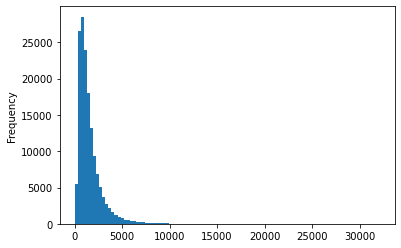

In [ ]:
# выведем гистограмму распределения длин отзывов в символах
symb_length.plot(kind = 'hist', bins = 100)

In [ ]:
# Посчитаем длину каждого отзыва в словах (без препроцессинга с помощью токенизаторов и т.п.)

# сначала разобьем каждый отзыв на отдельные слова
replies = [txt.split() for txt in df.text]

In [ ]:
# потом заполним счетчик слов в каждом отзыве
word_count = []
for i in replies:
  reply = str(i)
  word_count.append(len(reply.split()))

In [ ]:
word_count[:10]

[219, 140, 90, 123, 306, 82, 88, 102, 95, 200]

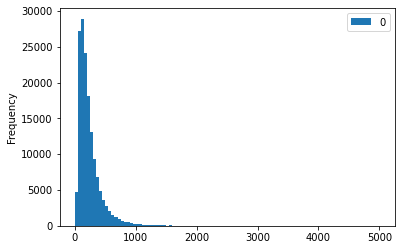

In [ ]:
# выведем гистограмму распределения длин отзывов в словах
word_count_df = pd.DataFrame(word_count)
word_count_df.plot(kind = 'hist', bins = 100)

Можно сделать вывод, что формы распределения частот в символах и словах практически одинаковы.

In [ ]:
# в) Найдите 10 самых частых:
# - слов (1)
# - слов без стоп-слов (2).
# - лемм (3).
# - существительных (4).

# (1) Для решения задачи нахождения 10-и самых частых слов (удалив только знаки пунктуации, т.е. без "тяжелой" предобработки) 
# воспользуемся самым простым способом - токенизатором 'word_tokenize' из библиотеки NLTK.
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# загрузим знаки пунктуации
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# загрузим счетчик
from collections import Counter

In [ ]:
# корпус для п.1 (без знаков пунктуации) создадим из 15000 позиций, чтобы уменьшить время обработки (см.далее лемматизацию также на 15000 позиций)
corpus = [token for response in df.text[:15000] for token in word_tokenize(response) if token not in punctuation]
print(len(corpus))
corpus[:5]

3198559


['Добрый', 'день', 'Я', 'не', 'являюсь']

In [ ]:
# прогоним корпус через счетчик
freq_dict = Counter(corpus)

# получим список 10 самых частых слов в корпусе (подвыборке из 15000 строк)
freq_dict.most_common(10)

[('в', 100299),
 ('и', 85275),
 ('не', 72429),
 ('на', 55723),
 ('что', 51958),
 ('с', 39389),
 ('я', 38879),
 ('по', 31471),
 ('мне', 25976),
 ('банка', 22109)]

In [ ]:
# (2) Для решения остальных задач из списка "10-и самых частых" сделаем более глубокий препроцессинг текста. Загрузим необходимые библиотеки, в т.ч. pymorphy2 (для п.3)
import re
from nltk.corpus import stopwords

In [ ]:
! pip install pymorphy2
import pymorphy2

m = pymorphy2.MorphAnalyzer()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 8.2 MB 48.5 MB/s 


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
] + list(punctuation)  #добавим знаки пунктуации к списку стоп-слов
ru_words = re.compile("[А-Яа-я]+")


def words_only(txt):
    return " ".join(ru_words.findall(txt))


def lemmatize(txt):
    try:
        return  " ".join([m.parse(w)[0].normal_form for w in txt.lower().split()])
    except:
        return " "


def remove_stopwords(txt, mystopwords = mystopwords):
    try:
        return " ".join([token for token in txt.split() if not token in mystopwords])
    except:
        return ""

# "тяжелый" препроцессинг (с лемматизацией)    
def preprocess(txt):
    return remove_stopwords(lemmatize(words_only(txt.lower())))

# "легкий" препроцессинг (без лемматизации)
def lite_preprocess(txt): 
    return remove_stopwords(words_only(txt.lower()))

In [ ]:
# (2) получим список 10-и самых частых слов без стоп-слов и знаков пунктуации.
response_without_stop = [token for response in df.text[:15000] for token in word_tokenize(response) if token not in mystopwords]
print(len(response_without_stop))
response_without_stop[:5]

2195586


['Добрый', 'день', 'Я', 'являюсь', 'клиентом']

In [ ]:
freq_dict = Counter(response_without_stop)

# попробуем получить список 10-и самых частых слов без стоп-слов (в подвыборке из 15000 строк)
freq_dict.most_common(10)

[('банка', 22109),
 ('``', 17924),
 ("''", 17731),
 ('банк', 15062),
 ('В', 13101),
 ('Я', 11871),
 ('деньги', 10020),
 ('карты', 8627),
 ('карту', 8052),
 ('...', 7705)]

Можно увидеть, что в список попали также сдвоенные и строенные знаки пунктуации ('``', "''", '...'), которые не входили в список пунктуации и поэтому не были удалены "в лоб" при первом проходе. Также в список входят цифры (не вошли в ТОП-10), что не очень хорошо. Попробуем избавиться от "мусора", используя функцию lite_preprocess (легкий препроцессинг без лемматизации).

In [ ]:
response_without_stop_improved = df.text.astype('str')[:15000].progress_apply(lite_preprocess)

100%|██████████| 15000/15000 [00:19<00:00, 755.65it/s] 


In [ ]:
# прогоним результат работы функции lite_preprocess через токенизатор, чтобы разбить на отдельные слова 
response_without_stop_improved = [token for response in response_without_stop_improved for token in word_tokenize(response) if token not in mystopwords]
print(len(response_without_stop_improved))
response_without_stop_improved[:5]

1929427


['добрый', 'день', 'являюсь', 'клиентом', 'банка']

In [ ]:
freq_dict = Counter(response_without_stop_improved)

# итоговый вариант списка 10-и самых частых слов без стоп-слов (в подвыборке из 15000 строк)
freq_dict.most_common(10)

[('банка', 26197),
 ('банк', 21025),
 ('деньги', 10789),
 ('карты', 8893),
 ('карту', 8414),
 ('день', 7156),
 ('г', 6972),
 ('кредит', 6862),
 ('банке', 6399),
 ('заявление', 6143)]

Мы видим, что сдвоенные и строенные знаки препинания, а также цифры, ушли.  Размер корпуса при этом сократился с 2195586 до 1929427 символов.

In [ ]:
# (3) Лемматизацию (включая остальной препроцессинг) проведем на основании подвыборки из 15000 позиций по причине большого времени на обработку.
# Обработка 15000 позиций заняла 15+ минут, т.е. весь массив из 153499 позиций лемматизировался бы около 2,5 часов.
response_lemmas = df.text.astype('str')[:15000].progress_apply(preprocess)

100%|██████████| 15000/15000 [15:29<00:00, 16.13it/s]


In [ ]:
response_lemmas

0        добрый день являться клиент банк поручитель кр...
1        добрый день являться держатель зарплатный карт...
2        здравствуйте дублировать заявление можайский д...
3        добрый день открыть расчётный счёт сбербанк юр...
4        г взять кредит ваш банк заявить сумма рубль го...
                               ...                        
14995    друг добрый день долгий время явиться ваш клие...
14996    здравствуйте хотеть оставить отзыв покупка вал...
14997    декабрь открыть вклад хит сезон срок месяц авт...
14998    банк тинькофф нравиться спасибо сервис отличны...
14999    добрый день хотеть сделать обращение банк необ...
Name: text, Length: 15000, dtype: object

In [ ]:
# прогоним результат лемматизации (работы функции preprocess) через токенизатор, чтобы разбить на отдельные слова
response_lemmas_tokenized = [token for response in response_lemmas for token in word_tokenize(response) if token not in mystopwords]
print(len(response_lemmas_tokenized))
response_lemmas_tokenized[:5]

1860128


['добрый', 'день', 'являться', 'клиент', 'банк']

In [ ]:
freq_dict = Counter(response_lemmas_tokenized)

# список 10-и самых частых лемм (в подвыборке из 15000 строк)
freq_dict.most_common(10)

[('банк', 63107),
 ('карта', 28032),
 ('день', 15204),
 ('деньга', 14577),
 ('кредит', 14235),
 ('сотрудник', 14041),
 ('всё', 13275),
 ('клиент', 12108),
 ('счёт', 10637),
 ('отделение', 10628)]

In [ ]:
# (4) Найдем 10 самых частых существительных. Воспользуемся обработанным списком лемм по выборке из 15000 позиций.

# сперва посмотрим на формат парсинга pymorhy, нас интересуют поля 'word' и 'tag'
m.parse(response_lemmas[1])

[Parse(word='добрый день являться держатель зарплатный карта выдать сбербанк россия год сменить фамилия предоставить банк документ копия новый паспорт свидетельство брак перевыпустить карта фамилия муж токарев мария александрович девичий секлетина возникнуть необходимость подключить услуга сбербанк онлайн получиться главный страница отображаться карта связаться технический специалист отделение сбербанк обслуживаться пояснить база банк всё ещ девичий фамилия секлетина предложить выслать скан необходимый документ выслать оставить контакт звонок дождаться ч з некоторый время звонить объяснять ситуация пробивать база числиться секлетина хотя карта перевыпустить ещё фамилия токарев связь истечение срок обслуживание высылать документ копия паспорт свидетельство брак результат ноль просить помочь разобраться ситуация уважение токарев мария александрович', tag=OpencorporaTag('NOUN,anim,masc,Patr sing,nomn'), normal_form='добрый день являться держатель зарплатный карта выдать сбербанк россия го

In [ ]:
# определим функцию выделения существительных из текста
def parsing_nouns(txt):
    try:
        return  " ".join([m.parse(w)[0].word for w in txt.lower().split() if 'NOUN' in m.parse(w)[0].tag])
    except:
        return " "

In [ ]:
# выделим список существительных из предобработанного списка лемм (подвыборка 15000 позиций)
response_nouns = response_lemmas.progress_apply(parsing_nouns)

100%|██████████| 15000/15000 [09:33<00:00, 26.16it/s]


In [ ]:
# повторно прогоним список существительных (работы функции parsing_nouns) через токенизатор, чтобы разбить на отдельные слова
response_nouns_tokenized = [token for response in response_nouns for token in word_tokenize(response) if token not in mystopwords]
print(len(response_nouns_tokenized))
response_nouns_tokenized[:5]

960261


['день', 'клиент', 'банк', 'поручитель', 'договор']

In [ ]:
freq_dict = Counter(response_nouns_tokenized)
freq_dict.most_common(10)

[('банк', 63107),
 ('карта', 28032),
 ('день', 15204),
 ('деньга', 14577),
 ('кредит', 14235),
 ('сотрудник', 14041),
 ('клиент', 12108),
 ('счёт', 10637),
 ('отделение', 10628),
 ('сумма', 10624)]

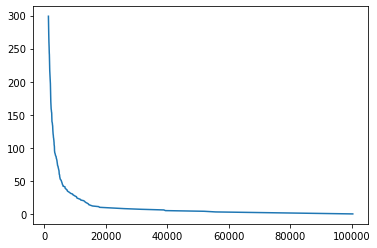

In [ ]:
# г) Построим кривые Ципфа и Хипса.
# В качестве основы возьмем полный корпус (все отзывы без препроцессинга), но можно было взять и после препроцессинга (например, без стоп-слов).
# Закономерность сохранилась бы и так, при условии достаточно большой выборки. На графике мы видим, что частотность использования слов в корпусе убывает очень быстро.
freq_dict = Counter(corpus)

# кривая Ципфа
import matplotlib.pyplot as plt
%matplotlib inline

freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:300], range(300))
plt.show()

In [ ]:
# Построим кривую Хипса. Расчет будем делать на подвыборке из 5000 позиций (для ускорения расчетов, 
# т.к. процедура расчета для построения кривой Хипса еще более ресурсозатратная, чем лемматизация текста.
# С увеличением корпуса растет количество сохраняемых счетчиков уникальных слов. 
# В Google Colab расчет по выборке из 5000 позиций занял 20+ минут, доступная оперативка практически закончилась.)

cnt = Counter()
n_words = []
n_tokens = []
tokens = []

for index, row in tqdm(df[:5000].iterrows(), total = len(df[:5000])):
  tokens = word_tokenize(row['text'])
  cnt.update([token for token in tokens if token not in punctuation])
  n_words.append(len(cnt))
  n_tokens.append([sum(i) for i in cnt.values()])

100%|██████████| 5000/5000 [20:43<00:00,  4.02it/s]


In [ ]:
# посчитаем отдельно сумму счетчиков токенов, иначе построение графика вылетает с ошибкой
sum_tokens = []
for i in n_tokens:
  sum_tokens.append(sum(i))

In [ ]:
sum_tokens[:10]

[222, 358, 451, 575, 883, 969, 1058, 1159, 1254, 1453]

In [ ]:
n_words[:10]

[170, 268, 319, 398, 551, 601, 648, 710, 770, 854]

На графике мы видим, как корпус постепенно насыщается новыми словами.

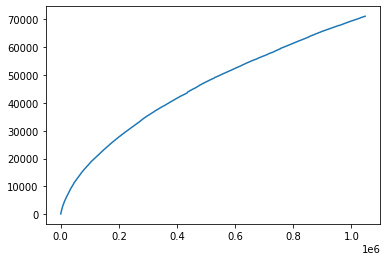

In [ ]:
fig, ax = plt.subplots()
ax.plot(sum_tokens, n_words)
plt.show()

In [ ]:
# д) Ответьте на следующие вопросы:
# - какое слово встречается чаще, "сотрудник" или "клиент"?
# - сколько раз встречаются слова "мошенничество" и "доверие"?

# Для ответа на эти вопросы воспользуемся корпусом лемм (response_lemmas_tokenized) на подвыборке 15000 позиций
freq_dict = Counter(response_lemmas_tokenized)

# - какое слово встречается чаще, "сотрудник" или "клиент"? Ответ: слово "сотрудник" встречается чаще, чем слово "клиент"
print("сотрудник:", freq_dict["сотрудник"])
print("клиент:", freq_dict["клиент"])

сотрудник: 14041
клиент: 12108


In [ ]:
# - сколько раз встречаются слова "мошенничество" и "доверие"? Ответ: слово "мошенничество" встречается 323 раза, слово "доверие" - 213 раз.
print("мошенничество:", freq_dict["мошенничество"])
print("доверие:", freq_dict["доверие"])

мошенничество: 323
доверие: 213


In [ ]:
# е) В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. 
# Используйте меру tf-idf для того, чтобы найти ключевые слова и биграммы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1).

df['rating_grade'].value_counts()
# Мы видим, что оценки проставлены лишь примерно в половине отзывов (88658 из 153499). С учетом этого факта, а также ограничения, 
# что в предыдущих пунктах ДЗ подвыборка была сделана на основании 15000 позиций без учета оценки отзыва, следует сделать новые подвыборки: 
# - для положительных отзывов (с оценкой 5) 
# - для отрицательных отзывов (с оценкой 1) 

1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: rating_grade, dtype: int64

In [ ]:
# - для положительных отзывов (с оценкой 5) 
df_positive_responses = df[['text', 'rating_grade']].loc[df['rating_grade'] == 5]
df_positive_responses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14713 entries, 98 to 153498
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          14713 non-null  object 
 1   rating_grade  14713 non-null  float64
dtypes: float64(1), object(1)
memory usage: 344.8+ KB


In [ ]:
# примеры положительных отзывов
df_positive_responses.text.head().tolist()

['Досрочно закрывали вклады перед отпуском. Жена заказывала заранее, но забыла заказать на меня. Сотрудник банка (СПБ Ленсовета 89) Наталья не отказала мне, хотя сумма значительная. Работает быстро, профессионально. Ничего лишнего. Жаль, что прикрыли прием вкладов в офисе Озерки - доступность офиса для меня. Заметил, что и несут деньги во вклады и берут кредиты. Желаю успехов банку.',
 'Хотел открыть вклад "Доходный+" под 19% год , проценты начисляются лесенкой 4 месяца 14%, потом 4 месяца 16%, потом 4 месяца 19%.\xa0 Но есть условие: Общий объем всех дополнительных взносов не может превышать 100% от суммы первоначального взноса по вкладу. А мне нужен вклад с возможностью пополнения.\xa0 Хорошо, \xa0значит сразу надо делать большой первоначальный взнос, пришел в офис банка в Нижнем Новгороде, спросил у операциониста: "Могу ли я открыть вклад Доходный и внести на него деньги межбанковским переводом?", ответ "Да, можете". Мне открыли: 1. счет вклада 2. текущий счет 3. счет карты (саму ка

In [ ]:
# сделаем препроцессинг(включая лемматизацию) отзывов с положительной оценкой
df_positive_responses.text = df_positive_responses.text.astype('str').progress_apply(preprocess)

100%|██████████| 14713/14713 [15:38<00:00, 15.68it/s]


In [ ]:
df_positive_responses.head()

,text,rating_grade
98,досрочно закрывать вклад отпуск жена заказыват...,5.0
122,хотеть открыть вклад доходный год процент начи...,5.0
157,вчера июнь просидеть очередь х час получение с...,5.0
259,сегодня открывать вклад банк очередь клиент за...,5.0
266,история получение кредит ренессанс кредит банк...,5.0


In [ ]:
# загрузим библиотеку для разбивки на n-граммы и TF-IDF-векторизатор
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# создадим векторизатор для разбивки на униграммы
positive_response_unigrams = TfidfVectorizer() # параметр ngram_range можно не задавать. По умолчанию - униграммы (1,1)

In [ ]:
# сформируем "мешок слов" с униграммами для полож.отзывов
bow_positive_unigrams = positive_response_unigrams.fit_transform(df_positive_responses.text)

In [ ]:
# способ подсчета ранга позаимствован из https://stackoverflow.com/questions/61213125/how-to-get-the-rank-of-inverse-document-frequency-idf-value-fof-all-the-terms
terms = positive_response_unigrams.get_feature_names_out()

# суммируем меру tf-idf каждого слова в "мешке слов"
sums = bow_positive_unigrams.sum(axis=0)

# объединяем каждое слово и его tf-idf, сортируем по убыванию
data = []
for col, term in enumerate(terms):
    data.append((term, sums[0, col]))

ranking = pd.DataFrame(data, columns=['Слово(униграмма)','Ранг по tf-idf'])
ranking = ranking.sort_values('Ранг по tf-idf', ascending=False)
ranking[:15]

,Слово(униграмма),Ранг по tf-idf
1370,банк,1212.915664
10664,карта,720.753085
4287,всё,560.482741
3473,вклад,515.325001
12102,кредит,492.520093
19921,очень,466.033703
19310,отделение,449.070038
6247,день,401.578905
11050,клиент,397.724856
29475,сотрудник,387.697028


In [ ]:
# Теперь разобьём положительные отзывы на биграммы. Может быть, получится более информативно, чем разбивка на униграммы.
# Создадим векторизатор для разбивки на биграммы
positive_response_bigrams = TfidfVectorizer(ngram_range=(2, 2))

In [ ]:
# сформируем "мешок слов" с биграммами для полож.отзывов
bow_positive_bigrams = positive_response_bigrams.fit_transform(df_positive_responses.text)

In [ ]:
terms = positive_response_bigrams.get_feature_names_out()

# суммируем меру tf-idf каждой биграммы в "мешке слов"
sums = bow_positive_bigrams.sum(axis=0)

# объединяем каждую биграмму и её tf-idf, сортируем по убыванию
data = []
for col, term in enumerate(terms):
    data.append((term, sums[0, col]))

ranking = pd.DataFrame(data, columns=['Биграмма','Ранг по tf-idf'])
ranking = ranking.sort_values('Ранг по tf-idf', ascending=False)
ranking[:15]

,Биграмма,Ранг по tf-idf
231675,интернет банк,87.804672
280969,кредитный карта,83.588668
696596,сотрудник банк,80.607950
257730,клиент банк,69.984112
430167,отделение банк,53.470469
823511,являться клиент,53.221081
674439,следующий день,51.661931
94538,всё вопрос,48.594002
11188,альфа банк,46.641128
153354,добрый день,43.540660


In [ ]:
# Теперь сделаем то же самое  для отрицательных отзывов (с оценкой 1) 
df_negative_responses = df[['text', 'rating_grade']].loc[df['rating_grade'] == 1]
df_negative_responses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47387 entries, 19 to 153497
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          47387 non-null  object 
 1   rating_grade  47387 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
# примеры отрицательных отзывов
df_negative_responses.text.head().tolist()

['Открыт вклад и счет в USD. Плюс к этому есть зарплатная карта, в рублях, само собой. Сегодня пришел в указанное отделение с целью пополнить долларовый счёт на 700 USD.\xa0Дал операционисту паспорт, зарплатную карту (т.к. на окошке написано "приготовьте карту для подтверждения операции" или что-то подобное и в прошлый раз у меня ее потребовали) и сказал, что нужно положить деньги на ДОЛЛАРОВЫЙ счет.\xa0Операционист всё взяла, что-то делала-крутила-вертела, вставила карту в терминал, сказала "введите пин", я ввёл пин, получил в ответ чек, где было написано, что доллары были внесены.... на счёт КАРТЫ! в РУБЛЯХ! Вопрос банку №1, риторический:  Я не понимаю, кем нужно быть, чтобы сознательно проводить такие операции??? за углом, меньше чем через квартал, курс приёма валюты выше почти на рубль! Если я действительно хотел совершить такую "хитрую" операцию, мне было выгоднее сделать 100 шагов и "заработать" на этом около 700 рублей, после чего просто внести рубли на счёт карты в банкомате! Д

In [ ]:
# сделаем препроцессинг(включая лемматизацию) отрицательных отзывов (47387 позиций отрабатывались на Колабе 1ч.03мин.)
df_negative_responses.text = df_negative_responses.text.astype('str').progress_apply(preprocess)

100%|██████████| 47387/47387 [1:03:10<00:00, 12.50it/s]


In [ ]:
df_negative_responses.head()

,text,rating_grade
19,открыть вклад счёт плюс зарплатный карта рубль...,1.0
33,добрый время вчера поступить смс уведомление б...,1.0
76,г около час прийти указанный офис намерение по...,1.0
85,оплата коммунальный платёж пользоваться пласти...,1.0
94,апрель год прийти отделение сбербанк г чапаевс...,1.0


In [ ]:
# создадим векторизатор для разбивки отриц.отзывов на униграммы
negative_response_unigrams = TfidfVectorizer() # параметр ngram_range можно не задавать. По умолчанию - униграммы (1,1)

In [ ]:
# сформируем "мешок слов" с униграммами для отриц.отзывов
bow_negative_unigrams = negative_response_unigrams.fit_transform(df_negative_responses.text)

In [ ]:
terms = negative_response_unigrams.get_feature_names_out()

# суммируем меру tf-idf каждого слова в "мешке слов"
sums = bow_negative_unigrams.sum(axis=0)

# объединяем каждое слово и его tf-idf, сортируем по убыванию
data = []
for col, term in enumerate(terms):
    data.append((term, sums[0, col]))

ranking = pd.DataFrame(data, columns=['Слово(униграмма)','Ранг по tf-idf'])
ranking = ranking.sort_values('Ранг по tf-idf', ascending=False)
ranking[:15]

,Слово(униграмма),Ранг по tf-idf
2177,банк,3687.049242
17042,карта,2882.469849
9980,деньга,1852.904103
19208,кредит,1616.473695
30770,отделение,1533.740422
9979,день,1531.045923
48523,счёт,1387.425495
14590,заявление,1341.214229
46818,сотрудник,1322.408247
6749,всё,1312.442526


In [ ]:
# Теперь разобьём отрицательные отзывы на биграммы. Создадим векторизатор для разбивки на биграммы
negative_response_bigrams = TfidfVectorizer(ngram_range=(2, 2))

In [ ]:
# сформируем "мешок слов" с биграммами для отриц.отзывов
bow_negative_bigrams = negative_response_bigrams.fit_transform(df_negative_responses.text)

In [ ]:
terms = negative_response_bigrams.get_feature_names_out()

# суммируем меру tf-idf каждой биграммы в "мешке слов"
sums = bow_negative_bigrams.sum(axis=0)

# объединяем каждую биграмму и её tf-idf, сортируем по убыванию
data = []
for col, term in enumerate(terms):
    data.append((term, sums[0, col]))

ranking = pd.DataFrame(data, columns=['Биграмма','Ранг по tf-idf'])
ranking = ranking.sort_values('Ранг по tf-idf', ascending=False)
ranking[:15]

,Биграмма,Ранг по tf-idf
1781544,сотрудник банк,317.620508
708932,кредитный карта,261.758262
348500,денежный средство,253.068538
1097422,отделение банк,249.661959
855053,написать заявление,242.413834
298748,горячий линия,217.022920
115006,ваш банк,179.882282
667710,колл центр,178.730245
1542741,рабочий день,175.409563
25787,альфа банк,172.231918


Часть 2. Тематическое моделирование.

а) Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [ ]:
# Воспользуемся мерами tf-idf и косинусной близости векторов tf-idf
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [ ]:
# Тематическое моделирование сделаем на основании корпуса лемм, сформированного в 1-ой части ДЗ (подвыборка из 15000 позиций).
texts = [text.split() for text in response_lemmas]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
len(corpus)

15000

In [ ]:
# создадим модель tf-idf на основании корпуса
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
# рассчитаем косинусную близость между векторами tf-idf
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

In [ ]:
# содержательный анализ тем проведем с использованием модели LSI (латентно-семантического анализа) из библиотеки Gensim
from gensim.models import lsimodel

In [ ]:
# сперва попробуем взять 10 тем
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=10)

CPU times: user 13.3 s, sys: 781 ms, total: 14 s
Wall time: 15.8 s


In [ ]:
lsi.show_topics()

[(0,
  '0.192*"карта" + 0.136*"кредит" + 0.117*"деньга" + 0.111*"вклад" + 0.109*"заявление" + 0.107*"счёт" + 0.102*"сумма" + 0.099*"отделение" + 0.098*"сотрудник" + 0.097*"номер"'),
 (1,
  '-0.246*"звонок" + -0.233*"номер" + 0.211*"вклад" + 0.208*"карта" + -0.188*"кредит" + -0.167*"ваш" + -0.152*"персональный" + -0.150*"данные" + -0.145*"поступать" + -0.141*"телефон"'),
 (2,
  '-0.639*"вклад" + 0.211*"карта" + 0.161*"сбербанк" + 0.161*"банкомат" + -0.140*"ставка" + -0.140*"договор" + -0.131*"процент" + -0.119*"условие" + -0.117*"открыть" + 0.106*"операция"'),
 (3,
  '-0.320*"кредит" + -0.309*"страховка" + 0.263*"вклад" + -0.212*"страхование" + 0.180*"номер" + -0.156*"погашение" + -0.153*"платёж" + -0.130*"сумма" + -0.129*"досрочный" + -0.128*"договор"'),
 (4,
  '-0.207*"средство" + -0.193*"договор" + -0.181*"денежный" + -0.167*"вклад" + -0.153*"руб" + 0.144*"заявка" + -0.144*"сумма" + -0.139*"комиссия" + -0.130*"счёт" + -0.127*"г"'),
 (5,
  '0.309*"страховка" + 0.263*"страхование" + -0

На основании модели LSI с использованием 10-и тем можно сделать вывод, что в целом вопросы касаются кредитных карт, страхования вкладов и задолженности, работы банкоматов. Пример: 9,
  '-0.266*"кошелёк" + 0.230*"банкомат" + -0.225*"киви" + -0.183*"платёж" + -0.146*"адресовать" + -0.145*"заявка" + -0.139*"обработка" + -0.137*"копия" + -0.129*"проделать" + -0.124*"мероприятие"')] - По всей видимости, отзыв касался  зачисления платежа в кошелек Киви через банкомат.

In [ ]:
# теперь попробуем взять 50 тем
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=50)

CPU times: user 13.1 s, sys: 774 ms, total: 13.9 s
Wall time: 11.1 s


In [ ]:
lsi.show_topics()

[(0,
  '0.192*"карта" + 0.136*"кредит" + 0.117*"деньга" + 0.111*"вклад" + 0.109*"заявление" + 0.107*"счёт" + 0.102*"сумма" + 0.099*"отделение" + 0.098*"сотрудник" + 0.097*"номер"'),
 (1,
  '0.245*"звонок" + 0.233*"номер" + -0.211*"вклад" + -0.208*"карта" + 0.188*"кредит" + 0.167*"ваш" + 0.152*"персональный" + 0.149*"данные" + 0.145*"поступать" + 0.142*"телефон"'),
 (2,
  '-0.639*"вклад" + 0.211*"карта" + 0.162*"сбербанк" + 0.162*"банкомат" + -0.141*"ставка" + -0.140*"договор" + -0.130*"процент" + -0.119*"условие" + -0.116*"открыть" + 0.106*"операция"'),
 (3,
  '0.320*"кредит" + 0.308*"страховка" + -0.265*"вклад" + 0.213*"страхование" + -0.180*"номер" + 0.156*"погашение" + 0.153*"платёж" + 0.130*"сумма" + 0.129*"досрочный" + 0.128*"договор"'),
 (4,
  '0.206*"средство" + 0.192*"договор" + 0.180*"денежный" + 0.168*"вклад" + 0.152*"руб" + -0.147*"заявка" + 0.145*"сумма" + 0.139*"комиссия" + 0.132*"счёт" + 0.130*"г"'),
 (5,
  '0.307*"страховка" + 0.268*"страхование" + -0.236*"платёж" + 0.21

В целом картина не изменилась, но можно сделать вывод, что для качественного тематического моделирования необходима более качественная предобработка корпуса. Например, следует расширить список стоп-слов (добавить в него слова "р", "г", "ст", "сч", "л", "ваш"), т.е. убрать сокращения и слова, не несущие существенной смысловой нагрузки, но усложняющие тематическое моделирование по причине высокой повторяемости в запросах.

**б) Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?**

Ответ: 
(2,
  '-0.639*"вклад" + 0.211*"карта" + 0.162*"сбербанк" + 0.162*"банкомат" + -0.141*"ставка" + -0.140*"договор" + -0.130*"процент" + -0.119*"условие" + -0.116*"открыть" + 0.106*"операция"'). - Тематика: Работа со вкладами и картами Сбербанка.

(7,
  '-0.521*"банкомат" + -0.169*"страховка" + -0.161*"купюра" + -0.159*"деньга" + 0.145*"кошелёк" + 0.133*"сбербанк" + -0.116*"комиссия" + -0.113*"чек" + -0.111*"руб" + 0.107*"киви"'). -Тематика: связана с некорректной работой банкомата при переводе с/на кошелек Киви из/в Сбербанк.

(11,
  '0.493*"сбербанк" + -0.281*"заявка" + -0.196*"банкомат" + -0.168*"кредитный" + -0.161*"карта" + 0.158*"перевод" + -0.128*"рассмотрение" + -0.128*"лимит" + 0.124*"онлайн" + 0.113*"счёт"'). - Тематика:  связана с заявкой на кредитную карту через банкомат Сбербанка.

 (14,
  '0.345*"курс" + -0.295*"перевод" + -0.286*"заявка" + 0.197*"евро" + 0.194*"рубль" + -0.194*"сбербанк" + -0.173*"кредит" + -0.164*"комиссия" + -0.155*"средство" + 0.146*"валюта"'). - Тематика: связана с курсом перевода из/в евро в/из рублей при погашении кредита Сбербанка. 

 (46,
  '-0.185*"стандарт" + 0.184*"услуга" + -0.183*"русский" + 0.176*"служба" + -0.170*"офис" + -0.169*"страховой" + 0.162*"отделение" + 0.152*"рубль" + -0.141*"смс" + 0.130*"поддержка"'). - Тематика: связана с оформлением страховки в офисе/отделении банка "Русский стандарт".

**Часть 3. Классификация текстов.**

а) Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

б) Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных n-грам.

In [ ]:
df['rating_grade'].value_counts()

1.0    47387
5.0    14713
2.0    13509
3.0     9261
4.0     3788
Name: rating_grade, dtype: int64

In [ ]:
# Как видим, множества отрицательных (с оценкой 1) и положительных отзывов (с оценкой 5) сильно разбалансированы: отрицательных в 3 раза больше, чем положительных.
# Поэтому для создания сбалансированной модели возьмем все положительные отзывы и примерно столько же отрицательных (или чуть больше для сохранения тренда).

# для положительных
N2 = len(df[df['rating_grade'] == 5])
N2

14713

In [ ]:
# для отрицательных
N1 = round(len(df[df['rating_grade'] == 1])*0.35)
N1

16585

In [ ]:
# выборка отрицательных
negative_sample = df[df['rating_grade'] == 1][['text', 'rating_grade']].sample(N1)
negative_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16585 entries, 13080 to 119107
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          16585 non-null  object 
 1   rating_grade  16585 non-null  float64
dtypes: float64(1), object(1)
memory usage: 388.7+ KB


In [ ]:
# выборка положительных
positive_sample = df[df['rating_grade'] == 5][['text', 'rating_grade']].sample(N2)
positive_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14713 entries, 103837 to 139923
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          14713 non-null  object 
 1   rating_grade  14713 non-null  float64
dtypes: float64(1), object(1)
memory usage: 344.8+ KB


In [ ]:
# объединим выборки
sum_sample = pd.concat([negative_sample, positive_sample])
sum_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31298 entries, 13080 to 139923
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   text          31298 non-null  object 
 1   rating_grade  31298 non-null  float64
dtypes: float64(1), object(1)
memory usage: 733.5+ KB


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
# входящие признаки (исходный текст отзывов, без векторизации)
x = sum_sample['text']

# создадим и обучим векторизатор tf-idf на отдельных словах - униграммах (с параметрами "по умолчанию")
tfidf = TfidfVectorizer()
x_vectorized = tfidf.fit_transform(x)
print("x_vectorized.shape: ", x_vectorized.shape)

# целевая переменная (не требует векторизации)
y = sum_sample['rating_grade']

x_vectorized.shape:  (31298, 160934)


In [ ]:
# 30% на тест-выборку
x_train, x_test, y_train, y_test = train_test_split(x_vectorized, y, test_size=0.3, random_state=21)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((21908, 160934), (9390, 160934), (21908,), (9390,))

In [ ]:
# загрузим необходимые библиотеки
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
# Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. 
# Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных n-грам.

# Обучим модель в базовом варианте (на униграммах) с использованием алгоритма случайного леса 
# (показывающего в ряде случаев лучшие результаты классификации по сравнению с логистической регрессией).
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
# Сделаем прогноз на тестовой выборке и выведем метрики
rfc_test = rfc.predict(x_test)
print(classification_report(rfc_test, y_test))

              precision    recall  f1-score   support

         1.0       0.96      0.90      0.93      5333
         5.0       0.88      0.95      0.91      4057

    accuracy                           0.92      9390
   macro avg       0.92      0.93      0.92      9390
weighted avg       0.93      0.92      0.92      9390



Результаты предсказаний с использованием RandomForest на униграммах получились неплохими. Попробуем теперь разбить текст только на биграммы.

In [ ]:
tfidf_bigrams = TfidfVectorizer(ngram_range = (2, 2))
x_vectorized_bigrams = tfidf_bigrams.fit_transform(x)
print("x_vectorized_bigrams.shape: ", x_vectorized_bigrams.shape)

x_vectorized_bigrams.shape:  (31298, 2499028)


In [ ]:
# 30% на тест-выборку
x_train, x_test, y_train, y_test = train_test_split(x_vectorized_bigrams, y, test_size=0.3, random_state=21)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((21908, 2499028), (9390, 2499028), (21908,), (9390,))

In [ ]:
# Обучим модель на биграммах с использованием алгоритма случайного леса
rfc_bi = RandomForestClassifier()
rfc_bi.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
# Сделаем прогноз на тестовой выборке и выведем метрики
rfc_test_bi = rfc_bi.predict(x_test)
print(classification_report(rfc_test_bi, y_test))

              precision    recall  f1-score   support

         1.0       0.93      0.86      0.90      5381
         5.0       0.83      0.91      0.87      4009

    accuracy                           0.88      9390
   macro avg       0.88      0.89      0.88      9390
weighted avg       0.89      0.88      0.89      9390



Мы видим, что качество предсказаний при использовании только биграмм ухудшилось по сравнению с использованием только униграмм. Попробуем теперь разбить на триграммы.

In [ ]:
tfidf_trigrams = TfidfVectorizer(ngram_range = (3, 3))
x_vectorized_trigrams = tfidf_trigrams.fit_transform(x)
print("x_vectorized_trigrams.shape: ", x_vectorized_trigrams.shape)

x_vectorized_trigrams.shape:  (31298, 5288559)


In [ ]:
# 30% на тест-выборку
x_train, x_test, y_train, y_test = train_test_split(x_vectorized_trigrams, y, test_size=0.3, random_state=21)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((21908, 5288559), (9390, 5288559), (21908,), (9390,))

In [ ]:
# Обучим модель на триграммах с использованием алгоритма случайного леса (обучение в Colab на 5,3 млн.признаков заняло 1 час)
rfc_tri = RandomForestClassifier()
rfc_tri.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
# Сделаем прогноз на тестовой выборке и выведем метрики
rfc_test_tri = rfc_tri.predict(x_test)
print(classification_report(rfc_test_tri, y_test))

              precision    recall  f1-score   support

         1.0       0.77      0.91      0.83      4212
         5.0       0.91      0.77      0.84      5178

    accuracy                           0.83      9390
   macro avg       0.84      0.84      0.83      9390
weighted avg       0.85      0.83      0.83      9390



Мы видим, что качество предсказаний при использовании только триграмм ухудшилось по сравнению с использованием только униграмм и только биграмм. Униграммы показали наилучшие результаты.
Попробуем теперь разбить на символьные n-граммы в диапазоне от 1(униграмм) до 3(триграмм).

In [ ]:
tfidf_ngrams = TfidfVectorizer(analyzer='char', ngram_range=(1, 3))
x_vectorized_ngrams = tfidf_ngrams.fit_transform(x)
print("x_vectorized_ngrams.shape: ", x_vectorized_ngrams.shape)

x_vectorized_ngrams.shape:  (31298, 73233)


In [ ]:
# 30% на тест-выборку
x_train, x_test, y_train, y_test = train_test_split(x_vectorized_ngrams, y, test_size=0.3, random_state=21)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((21908, 73233), (9390, 73233), (21908,), (9390,))

In [ ]:
# Обучим модель на n-граммах с использованием алгоритма случайного леса
rfc_ngrams = RandomForestClassifier()
rfc_ngrams.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
# Сделаем прогноз на тестовой выборке и выведем метрики
rfc_test_ngrams = rfc_ngrams.predict(x_test)
print(classification_report(rfc_test_ngrams, y_test))

              precision    recall  f1-score   support

         1.0       0.94      0.89      0.92      5274
         5.0       0.87      0.93      0.90      4116

    accuracy                           0.91      9390
   macro avg       0.91      0.91      0.91      9390
weighted avg       0.91      0.91      0.91      9390



Мы видим, что результаты предсказаний получились практически такими же хорошими, как с использованием только униграмм. Но использование символьных n-грамм дало прирост в производительности обучения (73233 признаков в n-граммах против 160934 в униграммах) - на небольшом корпусе разница незаметна, но для больших корпусов может иметь смысл использовать символьные n-граммы вместо униграмм.

Использование же биграмм и триграмм в данном конкретном случае особого смысла не имеет, т.к. существенно увеличивается время на обучение модели, а точность предсказаний ухудшается. Возможно, для увеличения скорости обучения следует использовать более простой векторизатор - CountVeсtorizer вместо TFidfVeсtorizer.

**в) Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:**

1-ый вариант: tf-idf преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентный семантический анализ) (sklearn.decomposition.TruncatedSVD),

2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации. В ноутбуке, размещенном в папке репозитория, написан примерный Pipeline для классификации текстов.

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

from gensim.models import lsimodel

In [ ]:
# входящие признаки (исходный текст отзывов, без векторизации)
x = sum_sample['text']

# целевая переменная (не требует векторизации)
y = sum_sample['rating_grade']

In [ ]:
# 30% на тест-выборку
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=21)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((21908,), (9390,), (21908,), (9390,))

In [ ]:
# создадим pipeline для расчета 1-го варианта, в этот раз попробуем CountVectorizer вместо TfidfVectorizer
clf_1 = Pipeline([ 
    ('vect', CountVectorizer(analyzer='char', ngram_range=(1,3))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])

In [ ]:
# обучим конвейер
clf_1.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()), ('tm', TruncatedSVD()),
                ('clf', RandomForestClassifier())])

In [ ]:
# Сделаем прогноз на тестовой выборке и выведем метрики
clf_1_pred = clf_1.predict(x_test)
print(classification_report(clf_1_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.72      0.70      0.71      5118
         5.0       0.65      0.67      0.66      4272

    accuracy                           0.69      9390
   macro avg       0.69      0.69      0.69      9390
weighted avg       0.69      0.69      0.69      9390



Мы видим, что качество предсказаний значительно ухудшилось с использованием     CountVectorizer, TfidfTransformer, TruncatedSVD, RandomForestClassifier. Возможно, следует "поиграть" параметрами этих методов.

Попробуем теперь LDA также в конвейере.

In [ ]:
clf_2 = Pipeline([ 
    ('vect', CountVectorizer(analyzer='char', ngram_range=(1,3))), 
    ('lda', LatentDirichletAllocation()), 
    ('clf', RandomForestClassifier())
])

In [64]:
# обучим конвейер
clf_2.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('lda', LatentDirichletAllocation()),
                ('clf', RandomForestClassifier())])

In [65]:
# Сделаем прогноз на тестовой выборке и выведем метрики
clf_2_pred = clf_2.predict(x_test)
print(classification_report(clf_2_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.87      0.84      0.85      5167
         5.0       0.81      0.84      0.83      4223

    accuracy                           0.84      9390
   macro avg       0.84      0.84      0.84      9390
weighted avg       0.84      0.84      0.84      9390



Мы видим, что результаты при LDA, CountVectorizer и небольших (от 1- до 3-) n-граммах получились почти такими же хорошими, как при использовании униграмм и небольших n-грамм с Tf-idf-векторизатором. Во всех случаях для классификации использовался "случайный лес". Возможно, что логистическая регрессия отработала бы быстрее без существенной потери качества.